In [1]:
import pandas as pd
import numpy as np
import os

import logging
logging.getLogger().setLevel(logging.INFO)

from alphabase.spectral_library.flat import SpecLibFlat
from alphabase.spectral_library.base import SpecLibBase
from alphabase.spectral_library.reader import LibraryReaderBase
from alphadia.extraction.utils import reannotate_fragments
from alphabase.psm_reader import psm_reader_provider

INFO:root:


In [2]:
import warnings 

def fragment_number(precursor_df, fragment_intensity_df) :
    if not set(['frag_start_idx', 'frag_stop_idx']).issubset(precursor_df.columns):
        warnings.warn('frag_start_idx and frag_stop_idx not in dataframe')
        return
    
    n_fragments = []
    
    for start, stop in zip(precursor_df['frag_start_idx'].values, precursor_df['frag_stop_idx'].values):
        n_fragments += [np.sum(fragment_intensity_df.iloc[start:stop].values > 0)]

    precursor_df['n_fragments'] = n_fragments

In [3]:
lib_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/library_MSFragger.tsv'
#insilico_lib_location = '/Users/georgwallmann/Documents/data/libraries/2022_111_brunner_2022_1ng_all_29_human_trypsin_diann_decoy.hdf'


In [4]:
# create dense library from diann psm file
target_lib = LibraryReaderBase()
target_lib.import_file(lib_location)

#target_lib._fragment_mz_df = target_lib._fragment_mz_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]
#target_lib._fragment_intensity_df = target_lib._fragment_intensity_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]

#target_lib._precursor_df['elution_group_idx'] = np.arange(len(target_lib._precursor_df))

,genes,mobility,precursor_mz,nAA,mods,mod_sites,proteins,sequence,rt,charge,frag_start_idx,frag_stop_idx,rt_norm,ccs
0,A2M,1.001362,612.347732,11,,,P01023,PLLVEPEGLEK,52.152066,2,0,10,0.241146,405.603595
1,AAAS,0.797581,429.284008,7,,,Q9NRG9,PVILLFR,79.394969,2,10,16,0.367114,324.597901
2,AAAS,0.873884,576.598386,16,,,Q9NRG9,LGGEAHSMVWDPSGER,28.944849,3,16,31,0.133838,529.216960
3,AAAS,0.942153,595.998149,15,,,Q9NRG9,IAHIPLYFVNAQFPR,87.393100,3,31,45,0.404097,570.412650
4,AAAS,0.991344,603.329873,11,,,Q9NRG9,FAVALLDDSVR,74.988304,2,45,55,0.346738,401.612808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52786,ZYX,1.286493,1091.045781,20,,,Q15942,VSSIDLEIDSLSSLLDDMTK,165.345772,2,723584,723603,0.764542,518.535157
52787,ZZEF1,0.843019,520.984998,18,Carbamidomethyl@C,12,O43149,DFTNYFGHLEGCGADLHK,64.175812,4,723603,723620,0.296742,679.778688
52788,ZZEF1,0.899994,637.354662,16,,,O43149,TLQFIQQLAHDLVQQK,111.384483,3,723620,723635,0.515030,544.615492
52789,ZZEF1,0.919307,589.837000,10,,,O43149,EFSVLTELLK,109.340688,2,723635,723644,0.505580,372.525978


In [5]:
target_lib._precursor_df['decoy'] = 0

In [6]:
target_lib._precursor_df['elution_group_idx'] = np.arange(len(target_lib._precursor_df))
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)

In [7]:
decoy_lib = SpecLibBase()
decoy_lib._precursor_df = target_lib.precursor_df.copy()
decoy_lib._fragment_mz_df = target_lib._fragment_mz_df.copy()
decoy_lib._fragment_intensity_df = target_lib._fragment_intensity_df.copy()

#decoy_lib.import_file(brunner_lib)
decoy_lib.decoy = 'diann'
decoy_lib.append_decoy_sequence()
decoy_lib.calc_precursor_mz()
decoy_lib.precursor_df = decoy_lib.precursor_df[decoy_lib.precursor_df['decoy'] == 1]

In [8]:
from peptdeep.pretrained_models import ModelManager
from alphabase.peptide.fragment import get_charged_frag_types

frag_types = get_charged_frag_types(
    ['b','y'], 
    2
)

model_mgr = ModelManager()

model_mgr.nce = 30
model_mgr.instrument = 'timsTOF'

In [9]:
res = model_mgr.predict_all(
    decoy_lib.precursor_df,
    predict_items=['ms2'],
    frag_types = frag_types,
)

2023-03-03 20:55:00> Using multiprocessing with 8 processes ...
2023-03-03 20:55:00> Predicting ms2 ...


100%|██████████| 42/42 [00:14<00:00,  2.98it/s]


In [10]:
decoy_lib._precursor_df = res['precursor_df']
decoy_lib._fragment_mz_df = res['fragment_mz_df']
decoy_lib._fragment_intensity_df = res['fragment_intensity_df']

In [11]:
decoy_lib._precursor_df[['frag_start_idx']] += len(target_lib._fragment_mz_df)
decoy_lib._precursor_df[['frag_stop_idx']] += len(target_lib._fragment_mz_df)

In [12]:
output_lib = SpecLibBase()

output_lib._precursor_df = pd.concat([target_lib._precursor_df, decoy_lib._precursor_df], join='inner')
output_lib._fragment_mz_df = pd.concat([target_lib._fragment_mz_df, decoy_lib._fragment_mz_df], join='inner')
output_lib._fragment_intensity_df = pd.concat([target_lib._fragment_intensity_df, decoy_lib._fragment_intensity_df], join='inner')

In [13]:
output_lib._precursor_df = output_lib._precursor_df.sort_values(by=['genes']).reset_index(drop=True)
output_lib._precursor_df['precursor_idx'] = np.arange(len(output_lib.precursor_df))

In [14]:
output_lib.precursor_df

,genes,mobility,precursor_mz,nAA,mods,mod_sites,proteins,sequence,rt,charge,frag_start_idx,frag_stop_idx,rt_norm,ccs,decoy,elution_group_idx,n_fragments,precursor_idx
0,A2M,1.001362,612.347732,11,,,P01023,PLLVEPEGLEK,52.152066,2,0,10,0.241146,405.603595,0,0,11,0
1,A2M,1.001362,598.332079,11,,,P01023,PVLVEPEGLDK,52.152066,2,830315,830325,0.241146,405.603595,1,0,11,1
2,AAAS,0.991344,631.361170,11,,,Q9NRG9,FLVALLDDSLR,74.988304,2,830445,830455,0.346738,401.612808,1,4,15,2
3,AAAS,1.110413,1188.616697,32,Carbamidomethyl@C,10,Q9NRG9,NTPVFELLPCGIIQGEPGAQPQLITFHPSFQK,122.008456,3,1375298,1375329,0.564155,669.714664,1,8,24,3
4,AAAS,0.797581,419.299656,7,,,Q9NRG9,PLILLLR,79.394969,2,727414,727420,0.367114,324.597901,1,1,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104103,ZZEF1,0.919307,589.837000,10,,,O43149,EFSVLTELLK,109.340688,2,723635,723644,0.505580,372.525978,0,52789,12,104103
104104,ZZEF1,0.919307,565.836997,10,,,O43149,ELSVLTELVK,109.340688,2,785202,785211,0.505580,372.525978,1,52789,12,104104
104105,ZZEF1,1.117669,842.425429,15,,,O43149,LISSTESELQQSYAK,27.982520,2,723644,723658,0.129388,451.330289,0,52790,21,104105
104106,ZZEF1,0.899994,628.010892,16,,,O43149,TVQFIQQLAHDLVQNK,111.384483,3,1088188,1088203,0.515030,544.615492,1,52788,24,104106


In [15]:
for i, (start_idx, stop_idx, k_allowed) in enumerate(zip(output_lib.precursor_df['frag_start_idx'].values, output_lib.precursor_df['frag_stop_idx'].values,output_lib.precursor_df['n_fragments'].values)):
    intensies = output_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values
    flat_intensities = np.sort(intensies.flatten())[::-1]
    output_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values[intensies <= flat_intensities[k_allowed]] = 0


In [16]:
fragment_number(output_lib.precursor_df, output_lib._fragment_intensity_df)

<AxesSubplot:xlabel='n_fragments', ylabel='Count'>

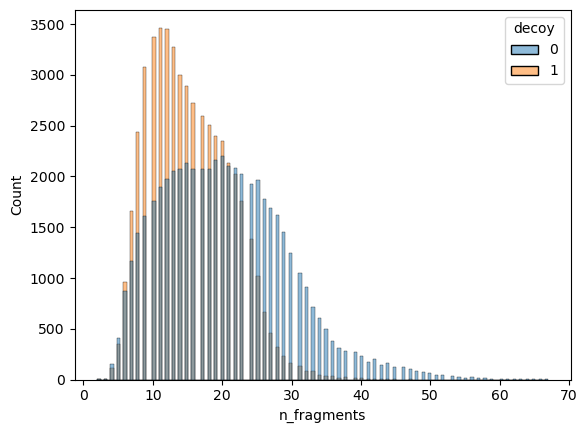

In [17]:
import seaborn as sns
sns.histplot(output_lib.precursor_df, x ='n_fragments', hue='decoy')

In [18]:
from tqdm import tqdm
from alphabase.peptide.precursor import get_mod_seq_formula
from alphabase.constants.isotope import IsotopeDistribution


def calc_isotope_dist(precursor_df, max_isotope = 6, min_intensity = 0.001):
    isotope_dist = IsotopeDistribution()

    col_names = ['i_{}'.format(i) for i in range(max_isotope)]
    precursor_df[col_names] = 0.

    for i in tqdm(range(len(precursor_df))):

        row = precursor_df.iloc[i]
        dist, mono = isotope_dist.calc_formula_distribution(
            get_mod_seq_formula(row['sequence'], row['mods'])
        )
        dist[dist < 0.001] = 0.
        dist = dist / dist.sum()
        precursor_df.loc[i, col_names] = dist[:max_isotope]

In [19]:
calc_isotope_dist(output_lib.precursor_df)

100%|██████████| 104108/104108 [00:38<00:00, 2718.63it/s]


In [20]:
output_lib._precursor_df.drop(columns=['rt'], inplace=True)

In [21]:
output_lib._precursor_df

,genes,mobility,precursor_mz,nAA,mods,mod_sites,proteins,sequence,charge,frag_start_idx,...,decoy,elution_group_idx,n_fragments,precursor_idx,i_0,i_1,i_2,i_3,i_4,i_5
0,A2M,1.001362,612.347732,11,,,P01023,PLLVEPEGLEK,2,0,...,0,0,11,0,0.497657,0.331727,0.126276,0.035046,0.007819,0.001476
1,A2M,1.001362,598.332079,11,,,P01023,PVLVEPEGLDK,2,830315,...,1,0,11,1,0.508699,0.327849,0.121770,0.033092,0.007246,0.001345
2,AAAS,0.991344,631.361170,11,,,Q9NRG9,FLVALLDDSLR,2,830445,...,1,4,13,2,0.484602,0.336975,0.131404,0.037067,0.008361,0.001590
3,AAAS,1.110413,1188.616697,32,Carbamidomethyl@C,10,Q9NRG9,NTPVFELLPCGIIQGEPGAQPQLITFHPSFQK,3,1375298,...,1,8,24,3,0.122183,0.241586,0.254392,0.188131,0.109010,0.052451
4,AAAS,0.797581,419.299656,7,,,Q9NRG9,PLILLLR,2,727414,...,1,1,7,4,0.604877,0.297089,0.080168,0.015493,0.002374,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104103,ZZEF1,0.919307,589.837000,10,,,O43149,EFSVLTELLK,2,723635,...,0,52789,12,104103,0.506262,0.329770,0.122382,0.033083,0.007183,0.001319
104104,ZZEF1,0.919307,565.836997,10,,,O43149,ELSVLTELVK,2,785202,...,1,52789,10,104104,0.528496,0.321389,0.113482,0.029398,0.006146,0.001090
104105,ZZEF1,1.117669,842.425429,15,,,O43149,LISSTESELQQSYAK,2,723644,...,0,52790,21,104105,0.399279,0.346622,0.170878,0.061271,0.017648,0.004303
104106,ZZEF1,0.899994,628.010892,16,,,O43149,TVQFIQQLAHDLVQNK,3,1088188,...,1,52788,16,104106,0.344858,0.352015,0.194918,0.076710,0.023874,0.006219


In [22]:
output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/library_MSFragger_new.hdf'
output_lib.save_hdf(output_location)

In [23]:
test_lib = SpecLibBase()
test_lib.load_hdf(output_location)

In [24]:
test_lib._precursor_df

,charge,decoy,frag_start_idx,frag_stop_idx,mod_seq_charge_hash,mod_seq_hash,precursor_mz,rt_norm,sequence
0,2,0,0,10,-5902435420383966768,-5902435420383966770,612.347732,0.241146,PLLVEPEGLEK
1,2,1,830315,830325,3766648993549763556,3766648993549763554,598.332079,0.241146,PVLVEPEGLDK
2,2,1,830445,830455,-6493297862235435738,-6493297862235435740,631.361170,0.346738,FLVALLDDSLR
3,3,1,1375298,1375329,-5108992742693614900,-5108992742693614903,1188.616697,0.564155,NTPVFELLPCGIIQGEPGAQPQLITFHPSFQK
4,2,1,727414,727420,6291183742222227837,6291183742222227835,419.299656,0.367114,PLILLLR
...,...,...,...,...,...,...,...,...,...
104103,2,0,723635,723644,2980994722975182420,2980994722975182418,589.837000,0.505580,EFSVLTELLK
104104,2,1,785202,785211,-5129586941915768509,-5129586941915768511,565.836997,0.505580,ELSVLTELVK
104105,2,0,723644,723658,-127859424326117553,-127859424326117555,842.425429,0.129388,LISSTESELQQSYAK
104106,3,1,1088188,1088203,3274813486705130588,3274813486705130585,628.010892,0.515030,TVQFIQQLAHDLVQNK
